# Ricoh GEN5 Waveform analysis HAB
## Configuration

1. Place Waveform files to analyze into [\\\p46.polytype.com\WpWiki-Media\internal\ipynb\Electronics\Wavefrom_Ricoh_Gen5\waveforms\](\\p46.polytype.com\WpWiki-Media\internal\ipynb\Electronics\Wavefrom_Ricoh_Gen5\waveforms\)
2. Change some constants to your likes

```
verbose      = False  # Print Tables with values
single_plots = False  # Each Waveform in a single Plot
multi_plot   = True   # Each Waveform in one 4x4 Subplots
```

3. Write a new line with your file: `print_waveform('waveforms/waveform.wav')`
4. Output will be displayed and also stored into [\\\p46.polytype.com\WpWiki-Media\internal\ipynb\Electronics\Wavefrom_Ricoh_Gen5\out\](\\p46.polytype.com\WpWiki-Media\internal\ipynb\Electronics\Wavefrom_Ricoh_Gen5\waveforms\)
    

## Usage
Example usage see below

In [1]:
# imports
import os
import binascii
import matplotlib.pyplot as plt
%matplotlib inline

# Configuration
# ============================================
#out_path = './out/'     # file output destination foder
#write_file = True       # write file block data to files

word_size              = 2   # number of bytes per data
number_of_waveforms    = 2   # stored in one waveform file
waveform_length        = 512 # lines in file per waveform
#waveform_length        = 256 # lines in file per waveform
resolution_of_waveform = 0.1 # us per line
waveform_data = [["MN_0",1],
                 ["MN_1",1],
                 ["MN_2",1],
                 ["MN_3",1],
                 ["DAC Data", 12]
                ]
verbose        = False  # Print Tables with values

In [2]:
def readInChunks(fileObj, chunkSize=2):
  """
  Lazy function to read a file piece by piece.
  """
  ary = []
  while True:
    data = fileObj.read(chunkSize)
    if not data:
      break
    # yield data      # if we like to have a generator
    ary.append(data)  # if we like to have an iterator (array)
  return ary

def bin_to_int(val):
  return int(binascii.hexlify(val), 16)

def bin_to_hexstr(val):
  return binascii.hexlify(val).decode("utf-8")

def int_to_binary(val):
  return "{0:0>16b}".format(val)

# Program Code
# ===================================================
# File Read & Analyze
def print_waveform(wave_files, single_plots = False, multi_plot = True, combined_plot = False):
  data = []
  for wave_file_idx in range(len(wave_files)):
    data.append([])
    data[wave_file_idx].append([])
    with open(wave_files[wave_file_idx], 'rb') as waveform:
      # read file to array in chunks
      words = readInChunks(waveform, word_size)
      # read data
      for wave in range(number_of_waveforms):
        time = 0.0 # us
        data[wave_file_idx].append([])
        if verbose:
          print('+-- {} => Waveform {} --+'.format(os.path.basename(wave_files[wave_file_idx]), wave))
          print("| Time [us] |    hex |                bin |  MN3-0 | Amplitude (DAC Value) |")
          print('+-----------+--------+--------------------+--------+-----------------------+')
        for i in range(0, waveform_length):
          idx = (wave*waveform_length) + i
          val_hex = bin_to_hexstr(words[idx])
          val_int = bin_to_int(words[idx])
          val_bin = int_to_binary(val_int)

          extracted_data = []
          idx = 0
          for j in range(len(waveform_data)):
            if waveform_data[j][1] == 1:
              extracted_data.append(val_bin[idx])
              idx = idx + waveform_data[j][1]
            else:
              extracted_data.append(val_bin[idx:idx+waveform_data[j][1]])
              idx = idx + waveform_data[j][1]

          # Fill Data Array
          data[wave_file_idx][wave].append([time, '0x'+str(val_hex), val_bin, extracted_data[0], extracted_data[1], extracted_data[2], extracted_data[3], int(extracted_data[4],2)])
          time = round(time+resolution_of_waveform,1)

        # Print
        if verbose:
          for dp in data[wave_file_idx][wave]:
            print("| {:>6} us | {} | 0b{} |   {}{}{}{} | {:<21} |".format(dp[0],dp[1],dp[2],dp[3],dp[4],dp[5],dp[6],dp[7]))

        if single_plots:
          # Plot waveform
          time = [col[0] for col in data[wave_file_idx][wave]]
          mn = []
          for col in data[wave_file_idx][wave]:
            mn.append(int("{}{}{}{}".format(col[3], col[4], col[5], col[6]),2)*100)
          amp = [col[7] for col in data[wave_file_idx][wave]]
          plt.plot(time, mn, 'r-', time, amp, 'b-')
          plt.xlabel('Time in [us]')
          plt.ylabel('MN and Amplitude')
          plt.title("{} => Waveform {}".format(os.path.basename(wave_files[wave_file_idx]), wave),y=1.08) 
          axes = plt.gca()
          axes.set_ylim([-1,max(amp)+100])
          plt.show()

      if multi_plot:
        # Plot waveform
        plt.figure(figsize=(30,40))
        fig, axes = plt.subplots(2, 2)
        fig.set_figheight(15)
        fig.set_figwidth(15)
        plt.suptitle(os.path.basename(wave_files[wave_file_idx]),y=1.01)
        for i in range(len(data[wave_file_idx])-1):
          plt.tight_layout()
          time = [col[0] for col in data[wave_file_idx][i]]
          mn = []
          for col in data[wave_file_idx][i]:
            mn.append(int("{}{}{}{}".format(col[3], col[4], col[5], col[6]),2)*100)
          amp = [col[7] for col in data[wave_file_idx][i]]
          if i == 0:
            p = axes[0,0]
          elif i == 1:
            p = axes[0,1]
          elif i == 2:
            p = axes[1,0]
          elif i == 3:
            p = axes[1,1]
          max_amp = max(amp[0:]) + 100
          p.plot(time, mn, 'r-', time, amp, 'b-')
          p.set_title("Waveform {}".format(i))
          p.set_ylim([-1,max_amp])
          p.set_xlabel('Time in [us]')
          p.set_ylabel('MN and Amplitude')
        plt.show()
        fig.savefig("./out/{}.png".format(os.path.splitext(os.path.basename(wave_files[wave_file_idx]))[0], dpi = 600))
  
  max_amp = 0
  if combined_plot:
        # Plot waveform
        plt.figure(figsize=(30,40))
        fig, axes = plt.subplots(2,2)
        fig.set_figheight(15)
        fig.set_figwidth(15)
        title = ""
        for file in wave_files:
          title = title + os.path.basename(file) + " VS "
        plt.suptitle(title,y=1.01)
        for j in range(len(data)):
          for i in range(len(data[j])-1):
            plt.tight_layout()
            time = [col[0] for col in data[j][i]]
            mn = []
            for col in data[j][i]:
              mn.append(int("{}{}{}{}".format(col[3], col[4], col[5], col[6]),2)*100)
            amp = [col[7] for col in data[j][i]]
            if i == 0:
              p = axes[0,0]
            elif i == 1:
              p = axes[0,1]
            elif i == 2:
              p = axes[1,0]
            elif i == 3:
              p = axes[1,1]
            if (max(amp[0:]) + 100) > max_amp:
              max_amp = max(amp[0:]) + 100
            #p.plot(time, mn, 'r-', time, amp, 'b-')
            legend_text = os.path.basename(wave_files[j])
            p.plot(time, mn, time, amp, label=legend_text)
            p.set_title("Waveform {}".format(i))
            p.set_ylim([-1,max_amp])
            p.set_xlabel('Time in [us]')
            p.set_ylabel('MN and Amplitude')
        plt.legend()
        plt.show()
        fig.savefig("./out/{}.png".format(os.path.splitext(os.path.basename(wave_files[wave_file_idx]))[0], dpi = 600))
        

## Steinemann Waveforms
### Comparing two waveforms

No handles with labels found to put in legend.


<Figure size 2160x2880 with 0 Axes>

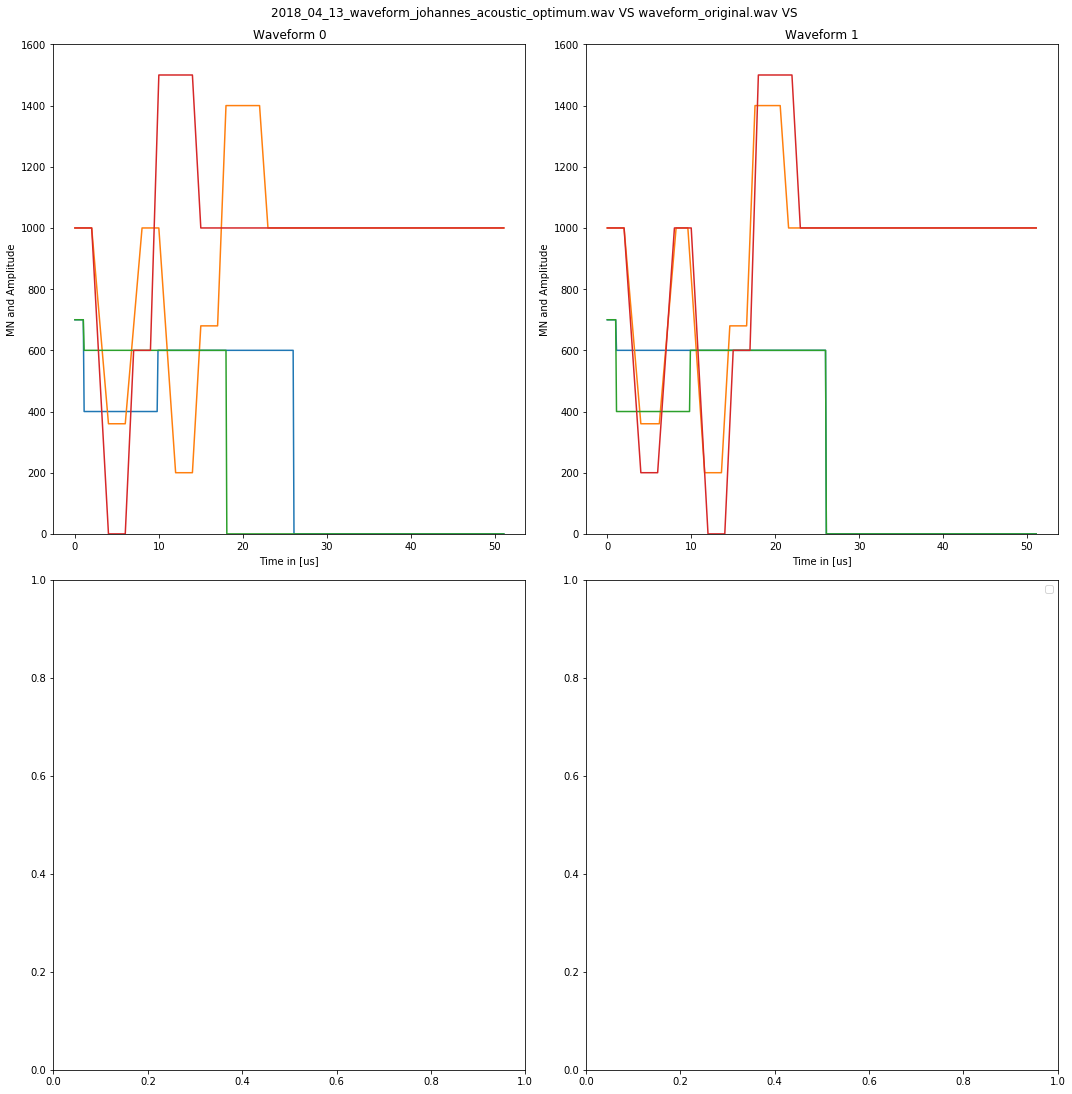

In [3]:
single_plots   = False  # Each Waveform in a single Plot
multi_plot     = False   # Each Waveform in one 4x4 Subplots
combined_plot  = True
print_waveform(['waveforms/2018_04_13_waveform_johannes_acoustic_optimum.wav', 'waveforms/waveform_original.wav'], single_plots, multi_plot, combined_plot)

<Figure size 2160x2880 with 0 Axes>

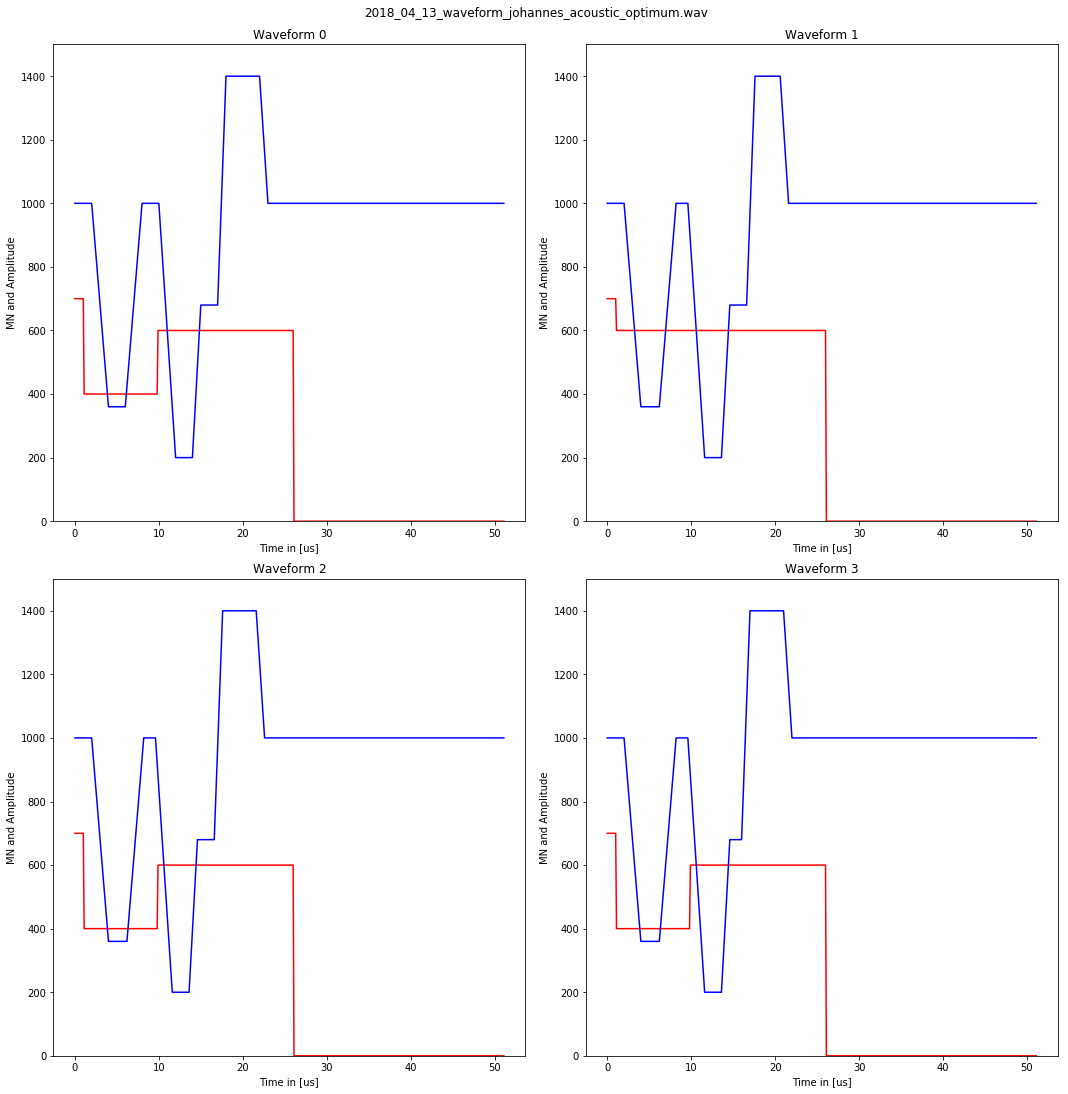

In [141]:
single_plots   = False  # Each Waveform in a single Plot
multi_plot     = True   # Each Waveform in one 4x4 Subplots
combined_plot  = False  # Each Waveform (for print_waveform_compare) in one plot
print_waveform_compare(['waveforms/2018_04_13_waveform_johannes_acoustic_optimum.wav'], single_plots, multi_plot, combined_plot)

<Figure size 2160x2880 with 0 Axes>

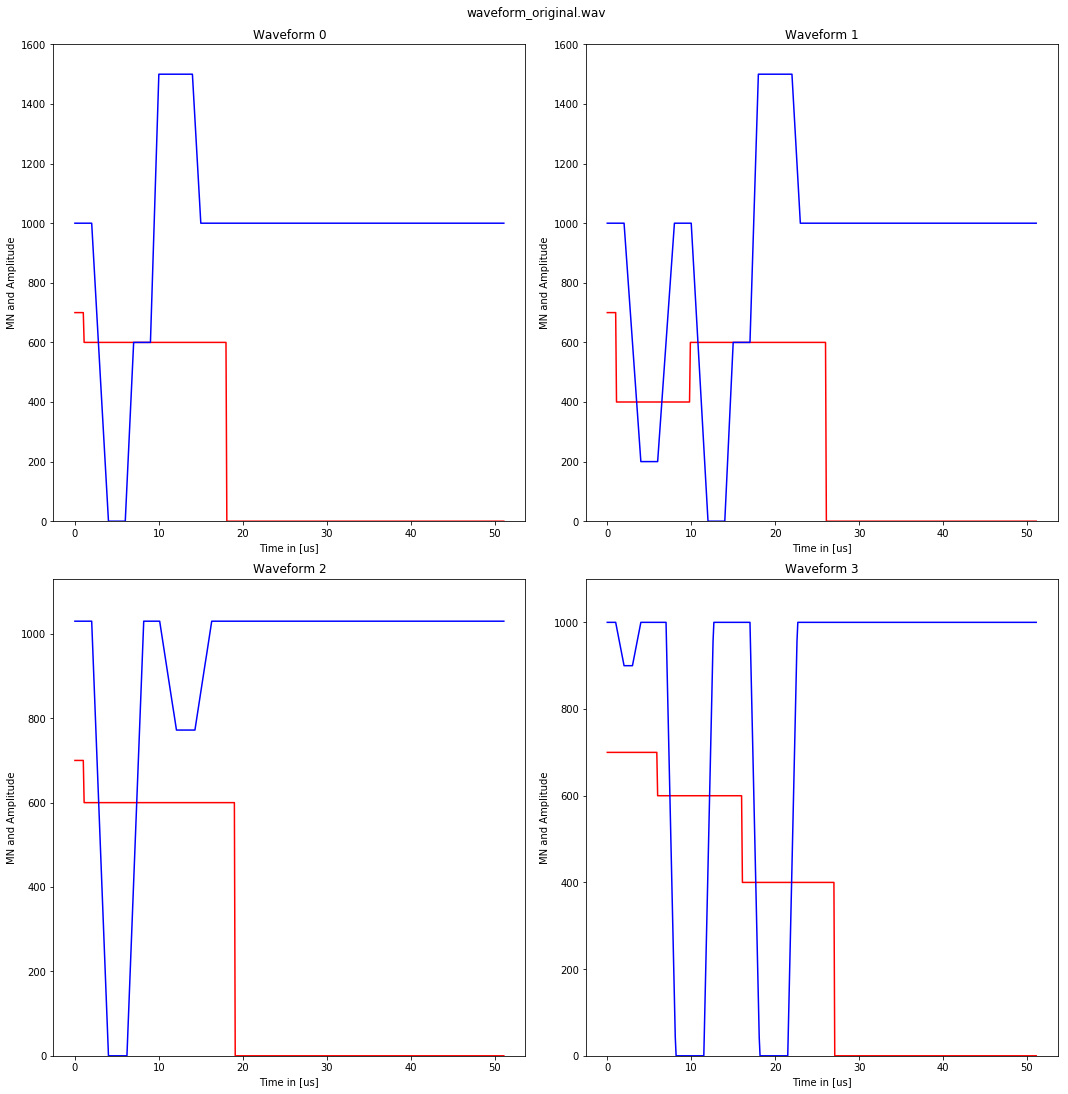

In [139]:
single_plots   = False  # Each Waveform in a single Plot
multi_plot     = True  # Each Waveform in one 4x4 Subplots
combined_plot  = False   # Each Waveform (for print_waveform_compare) in one plot
print_waveform(['waveforms/waveform_original.wav'], single_plots, multi_plot, combined_plot)

<Figure size 2160x2880 with 0 Axes>

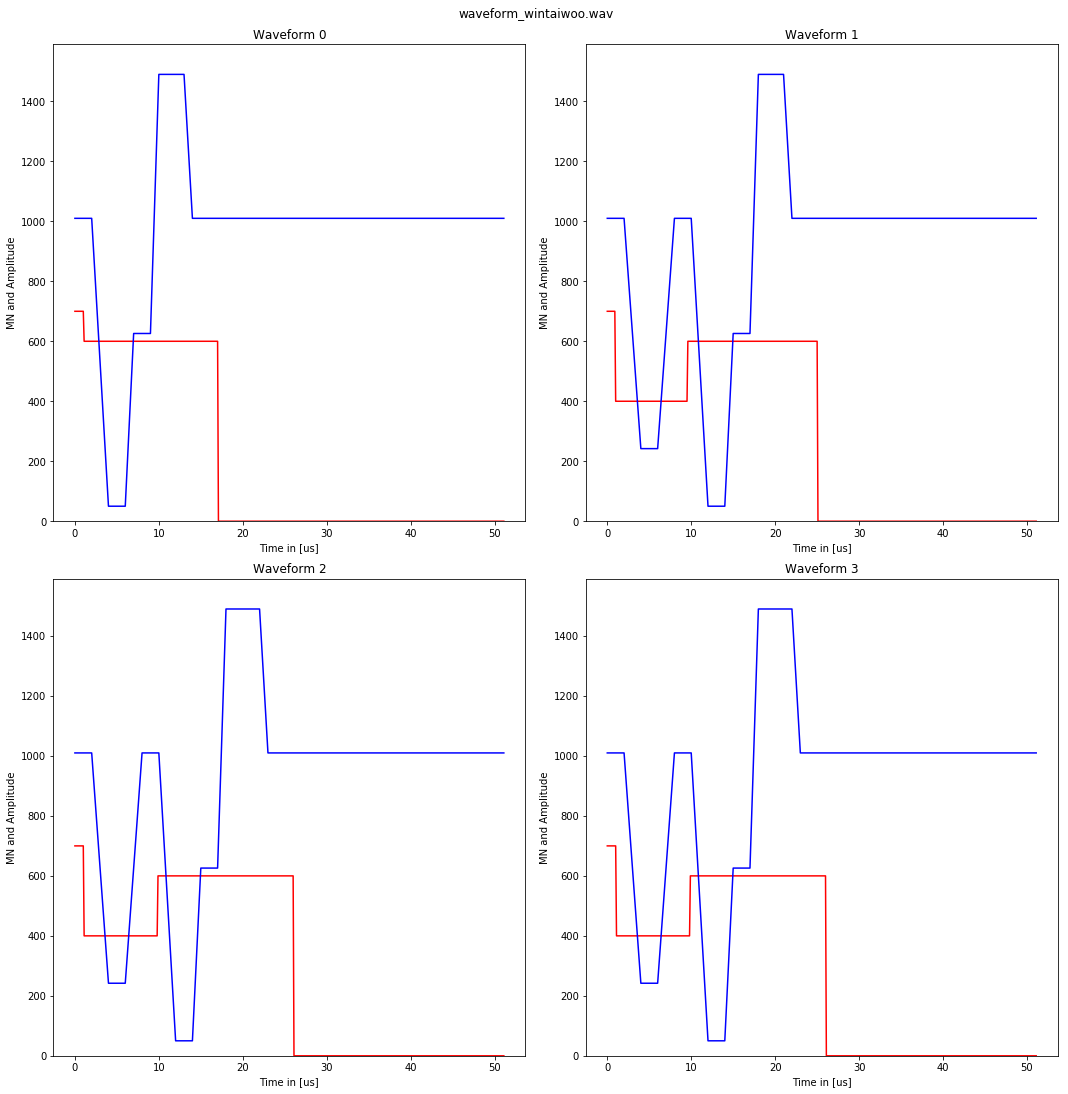

<Figure size 2160x2880 with 0 Axes>

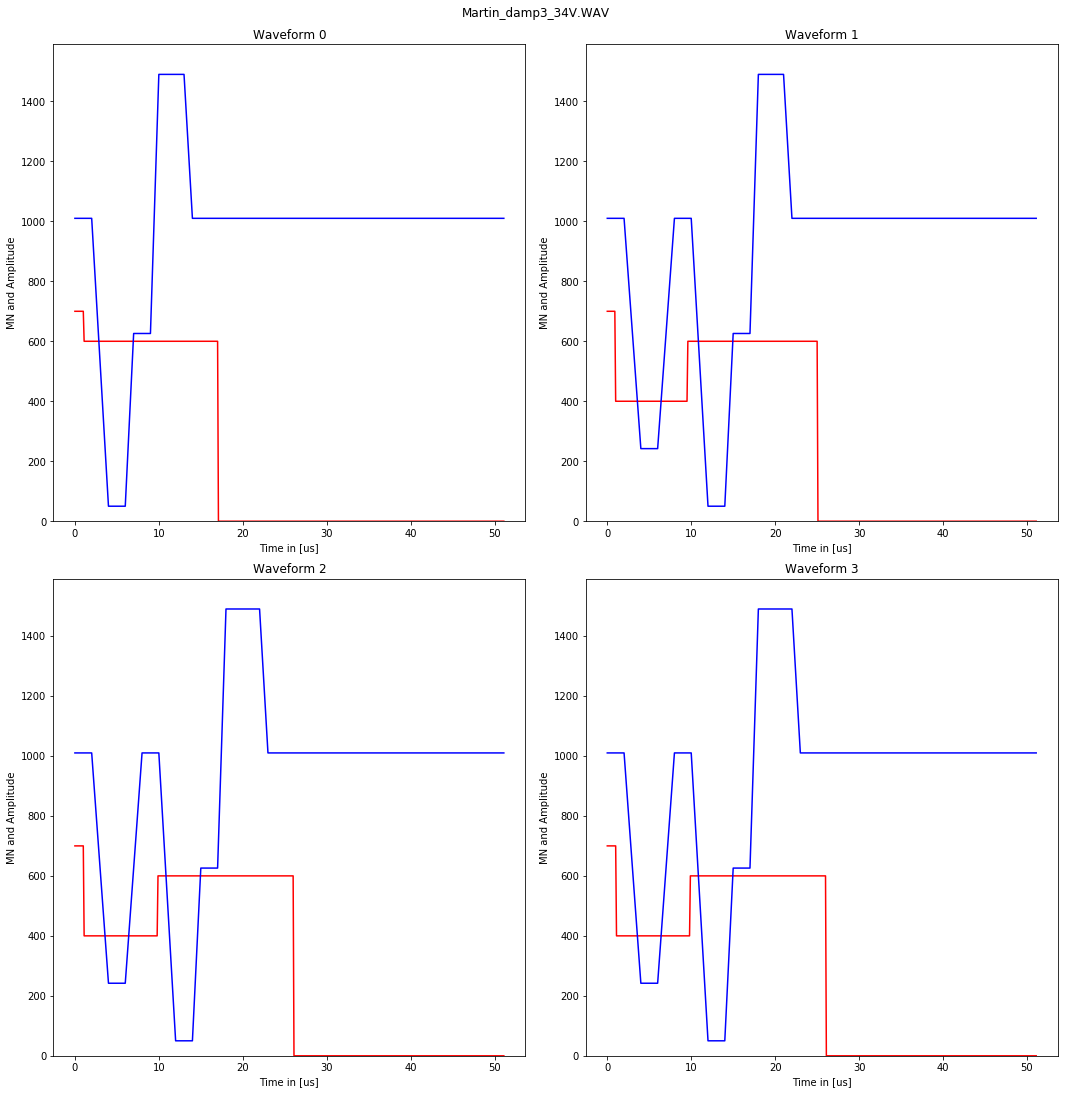

In [138]:
single_plots   = False  # Each Waveform in a single Plot
multi_plot     = True   # Each Waveform in one 4x4 Subplots
combined_plot  = False  # Each Waveform (for print_waveform_compare) in one plot
print_waveform(['waveforms/waveform_wintaiwoo.wav', 'waveforms/Martin_damp3_34V.WAV'], single_plots, multi_plot, combined_plot)

<Figure size 2160x2880 with 0 Axes>

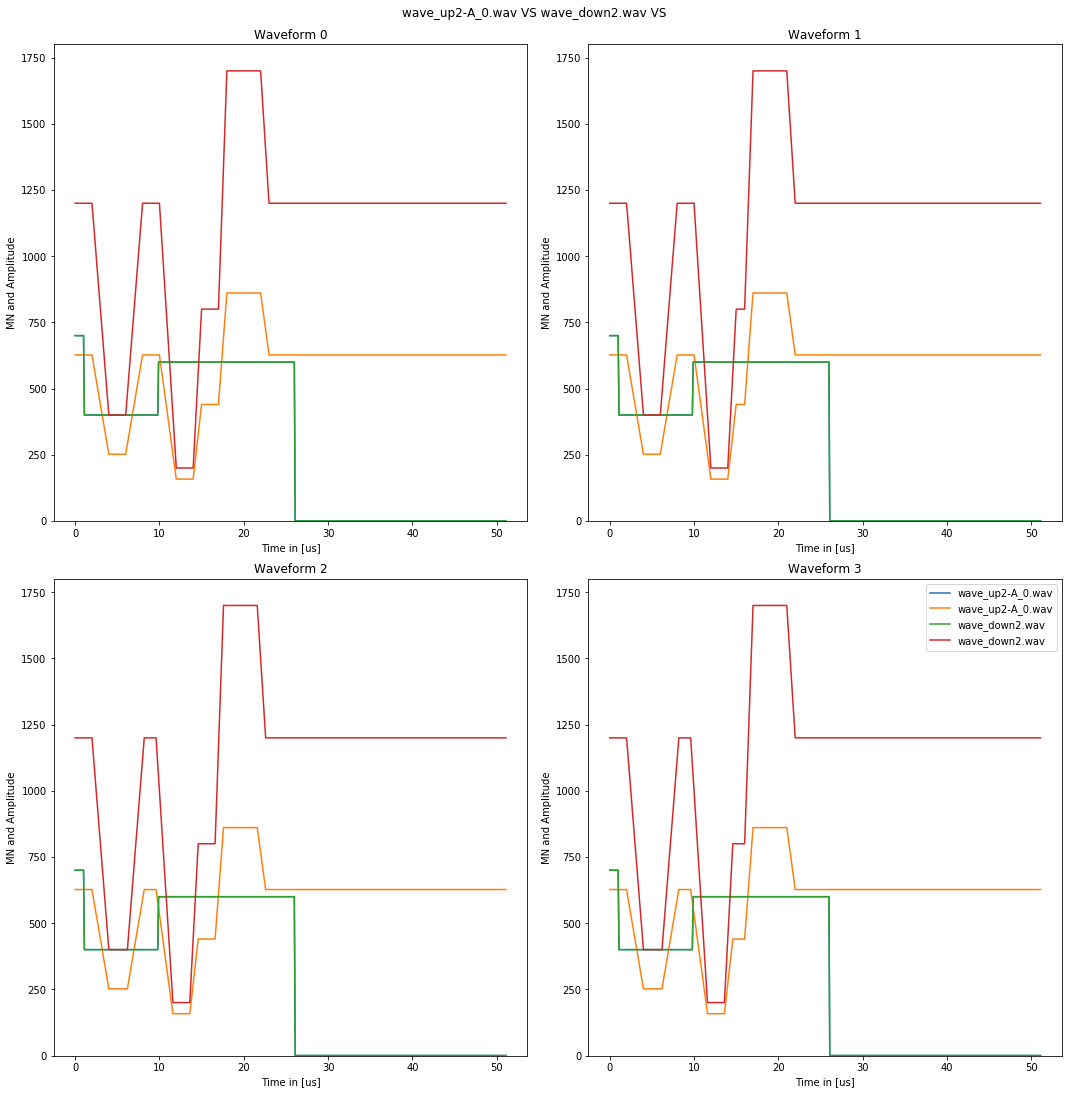

In [35]:
single_plots   = False  # Each Waveform in a single Plot
multi_plot     = False  # Each Waveform in one 4x4 Subplots
combined_plot  = True   # Each Waveform (for print_waveform_compare) in one plot
print_waveform(['waveforms/wave_up2-A_0.wav', 'waveforms/wave_down2.wav'], single_plots, multi_plot, combined_plot)

No handles with labels found to put in legend.


<Figure size 2160x2880 with 0 Axes>

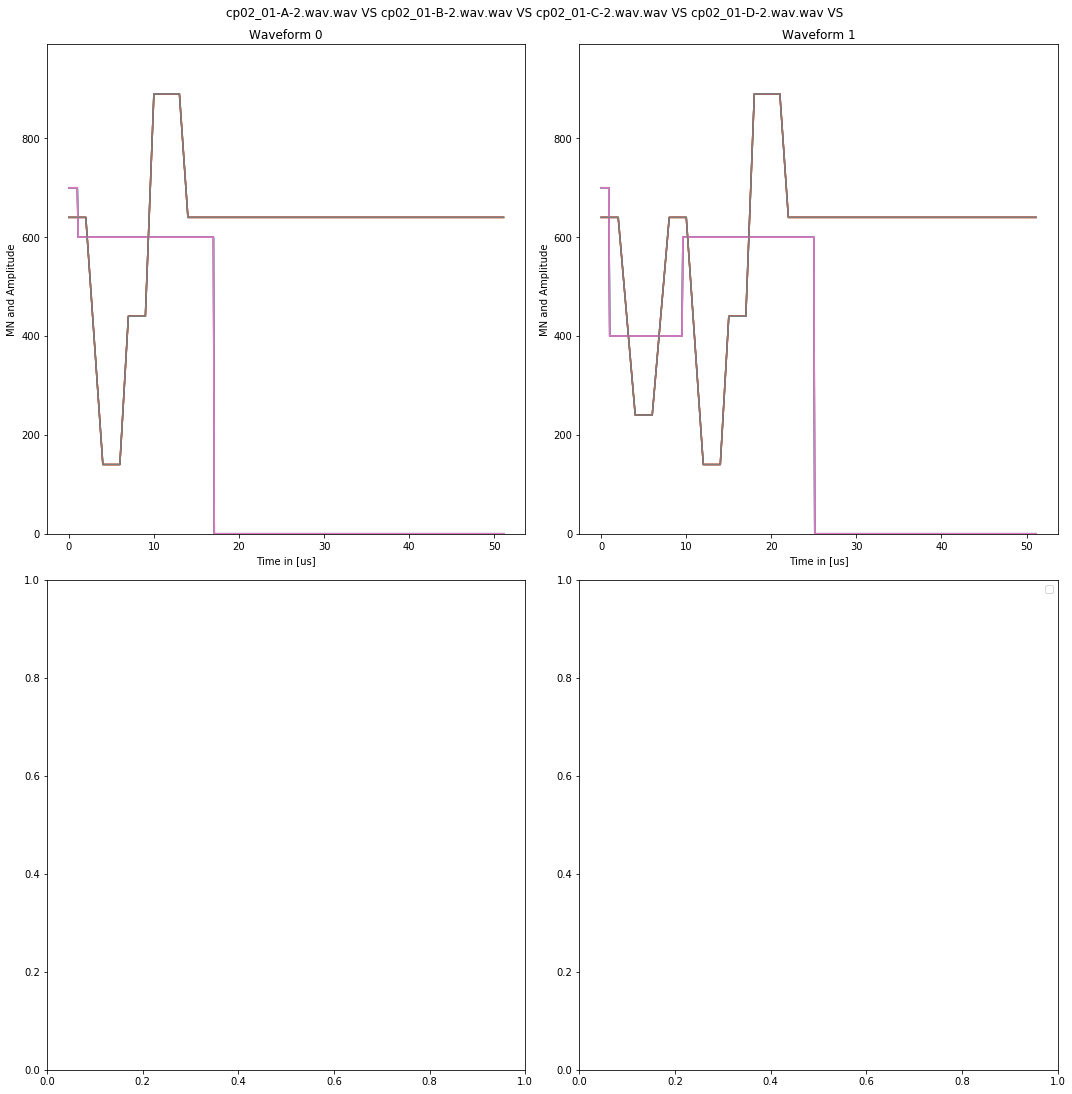

In [48]:
single_plots   = False  # Each Waveform in a single Plot
multi_plot     = False  # Each Waveform in one 4x4 Subplots
combined_plot  = True   # Each Waveform (for print_waveform_compare) in one plot
print_waveform(['waveforms/cp02_01-A-2.wav.wav', 'waveforms/cp02_01-B-2.wav.wav', 'waveforms/cp02_01-C-2.wav.wav', 'waveforms/cp02_01-D-2.wav.wav'], single_plots, multi_plot, combined_plot)


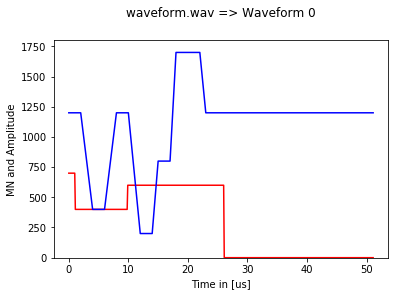

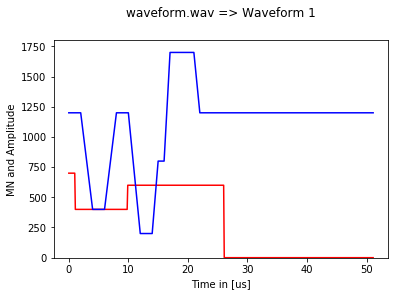

<Figure size 2160x2880 with 0 Axes>

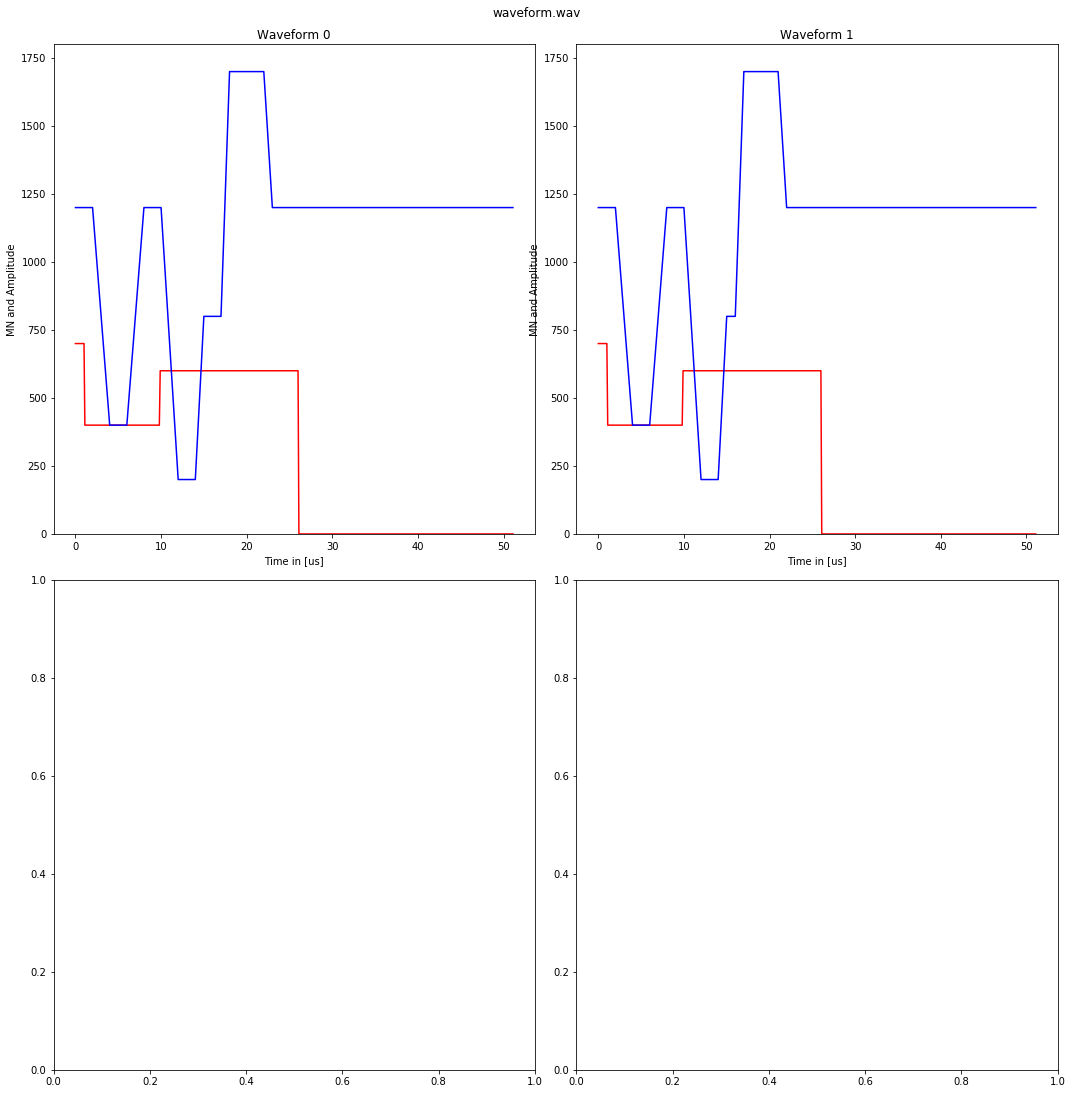

No handles with labels found to put in legend.


<Figure size 2160x2880 with 0 Axes>

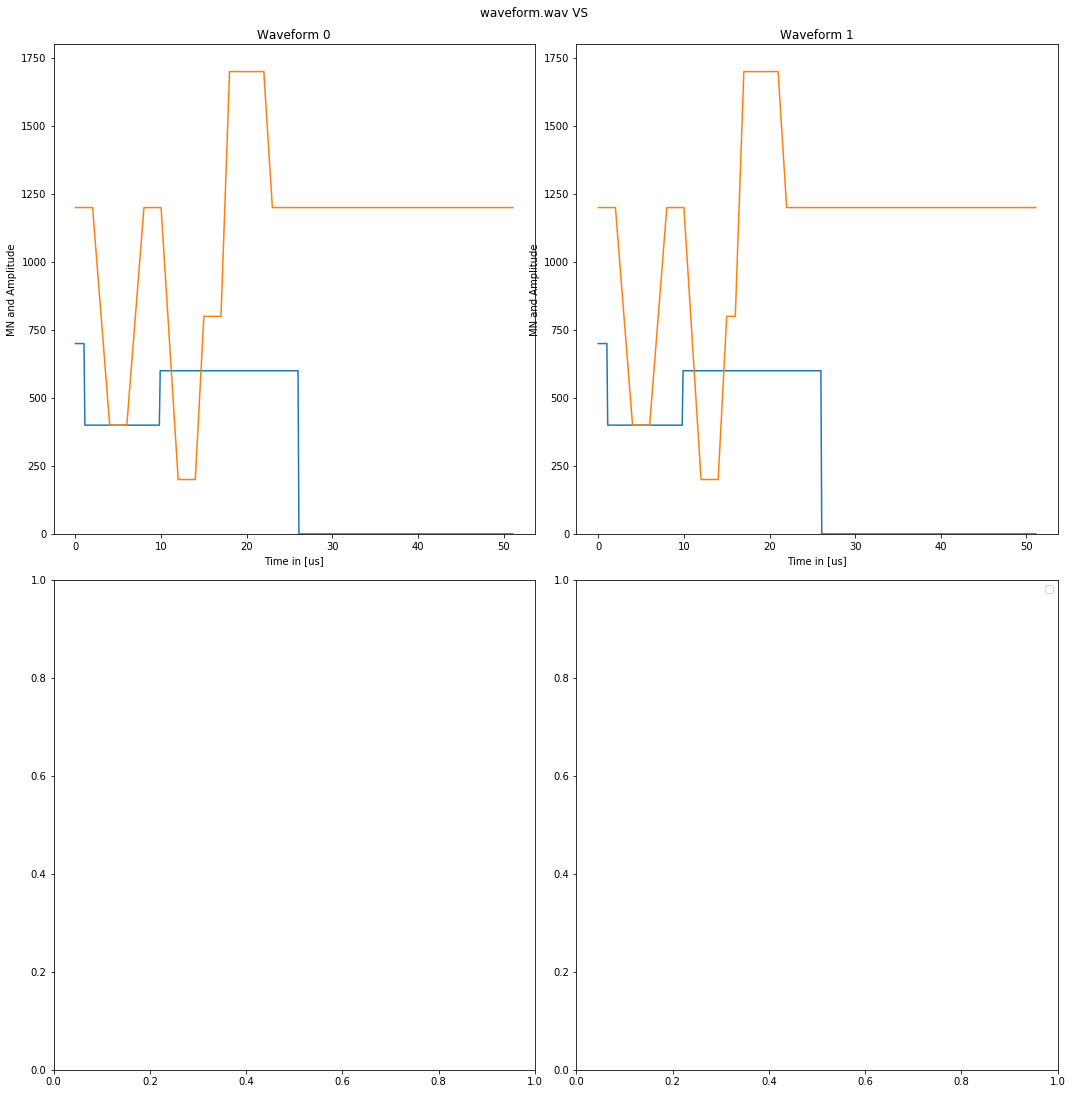

In [6]:
single_plots   = True  # Each Waveform in a single Plot
multi_plot     = True  # Each Waveform in one 4x4 Subplots
combined_plot  = True   # Each Waveform (for print_waveform_compare) in one plot
print_waveform(['waveforms/waveform.wav'], single_plots, multi_plot, combined_plot)
